In [1]:
# Import Libraries

# System
import os
import gc
import shutil
import time
import glob

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import random
import numpy as np 
import pandas as pd
import cv2
from tqdm import tqdm
tqdm.pandas()

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display, HTML

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping


2. Data Exploration

2.1. Train and Test Metadata

In [5]:
# Metadata
MAIN_PATH = "D:/Data Science/NYU/nyu_data/"
BASE_PATH = "D:/Data Science/NYU/nyu_data/data" 
TRAIN_PATH = os.path.join(BASE_PATH, "nyu2_train")
TEST_PATH = os.path.join(BASE_PATH, "nyu2_test")

df_metadata_train = pd.read_csv(os.path.join(BASE_PATH, "nyu2_train.csv"), header=None, names=["rgb", "depth"])
df_metadata_train["scene"] = df_metadata_train["rgb"].apply(lambda x: "_".join(x.split("/")[2].split("_")[:-2]))
df_metadata_test = pd.read_csv(os.path.join(BASE_PATH, "nyu2_test.csv"), header=None, names=["rgb", "depth"])

display(df_metadata_train)
display(df_metadata_test)


,rgb,depth,scene
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png,living_room
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png,living_room
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png,living_room
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png,living_room
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png,living_room
...,...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png,dining_room
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png,dining_room
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png,dining_room
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png,dining_room


,rgb,depth
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png
...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png


2.2. RGB Images and Corresponding Depth Maps

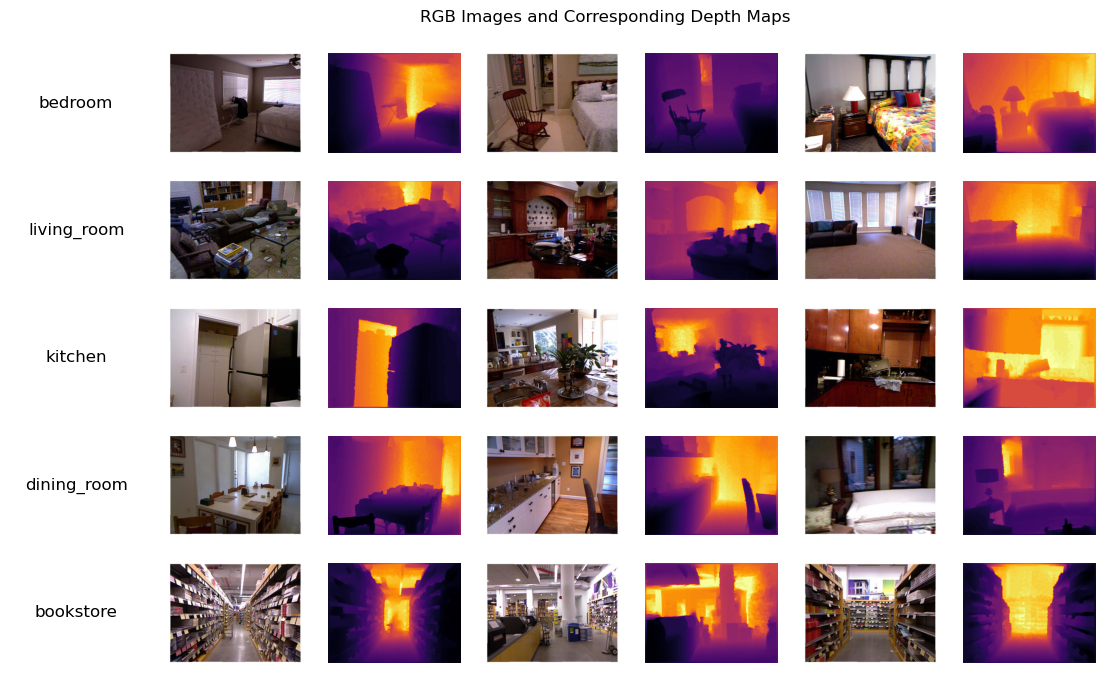

In [6]:
# Create Subplots
fig, axs = plt.subplots(5, 7, figsize=(14, 8))

# Data
scenes = list(df_metadata_train["scene"].value_counts().keys()[:5])
df_metadata_scene = df_metadata_train[df_metadata_train["scene"]==scenes[0]].reset_index(drop=True)
df_metadata_scene = df_metadata_scene.loc[[0, len(df_metadata_scene)-1], :].reset_index(drop=True)
df_metadata_scene

# Plot
for i, scene in enumerate(scenes):
    # Scene
    axs[i, 0].text(0.5, 0.5, scene, ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off')
    
    df_metadata_scene = df_metadata_train[df_metadata_train["scene"]==scene].reset_index(drop=True)
    df_metadata_scene = df_metadata_scene.loc[[0, len(df_metadata_scene)//2, len(df_metadata_scene)-1], :].reset_index(drop=True)
    
    for j in range(3):
        # RGB Image
        rgb_path = MAIN_PATH + df_metadata_scene.loc[j, "rgb"]
        rgb_image = cv2.imread(rgb_path)
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        axs[i, j*2+1].imshow(rgb_image)
        axs[i, j*2+1].axis('off')
        
        # Depth Image
        depth_path = MAIN_PATH + df_metadata_scene.loc[j, "depth"]
        depth_image = cv2.imread(depth_path)
        depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2GRAY)
        depth_image = np.expand_dims(depth_image, -1)
        axs[i, j*2+2].imshow(depth_image, cmap="inferno")
        axs[i, j*2+2].axis('off')

# Title
plt.suptitle("RGB Images and Corresponding Depth Maps", x=0.55, y=0.93)

# Show
plt.show()

2.3. Depth Distribution

In [7]:
def depth_statistics(image_path):
    img = cv2.imread(MAIN_PATH + image_path)
    depth_range = img.max() - img.min()
    mean = np.mean(img)
    std = np.std(img)
    return depth_range, mean, std

df_metadata_train["depth_range"], df_metadata_train["mean"], df_metadata_train["std"] = zip(*df_metadata_train['depth'].progress_apply(depth_statistics))
df_metadata_test["depth_range"], df_metadata_test["mean"], df_metadata_test["std"] = zip(*df_metadata_test['depth'].progress_apply(depth_statistics))

display(df_metadata_train)
display(df_metadata_test)


100%|████████████████████████████████████████████████████████████████████████████████| 654/654 [00:31<00:00, 20.54it/s]


,rgb,depth,scene,depth_range,mean,std
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png,living_room,223,93.306442,50.263732
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png,living_room,97,76.810316,22.220856
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png,living_room,229,100.978893,52.491114
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png,living_room,227,93.152998,51.268261
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png,living_room,176,78.140430,43.172204
...,...,...,...,...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png,dining_room,166,105.371042,50.255534
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png,dining_room,154,97.024310,46.218216
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png,dining_room,159,101.325937,48.613924
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png,dining_room,202,97.144268,37.550307


,rgb,depth,depth_range,mean,std
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png,7,10.731589,1.675725
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png,6,6.331501,1.475183
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png,25,8.951709,6.308503
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png,8,9.845566,1.262471
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png,34,12.194176,7.683139
...,...,...,...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png,23,10.948910,5.608204
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png,21,12.108630,5.328718
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png,17,9.702350,4.891516
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png,27,12.906738,6.976634


In [8]:
# Depth Distribution

# Create Subplots
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        "Training Range of Depth", "Training Mean", "Training Standard Deviation", 
        "Testing Range of Depth", "Testing Mean", "Testing Standard Deviation",
    ]
)

train_color = "#60442e"
test_color = "#83522e"

params = ["depth_range", "mean", "std"]
for i, param in enumerate(params): 
    # Training
    fig_distplot_train = ff.create_distplot(
        [df_metadata_train[param]], 
        ["Training"], 
        show_rug=False
    )
    
    fig.add_trace(go.Histogram(fig_distplot_train['data'][0], marker_color=train_color, hoverinfo="skip"), row=1, col=i+1)
    fig.add_trace(go.Scatter(fig_distplot_train['data'][1], line=dict(color=train_color, width=2)), row=1, col=i+1)
    
    # Testing
    fig_distplot_test = ff.create_distplot(
        [df_metadata_test[param]], 
        ["Testing"], 
        show_rug=False
    )
    
    fig.add_trace(go.Histogram(fig_distplot_test['data'][0], marker_color=test_color, hoverinfo="skip"), row=2, col=i+1)
    fig.add_trace(go.Scatter(fig_distplot_test['data'][1], line=dict(color=test_color, width=2)), row=2, col=i+1)
    
    # Update Axes
    fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_xaxes(linecolor="Black", ticks="outside", row=2, col=i+1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=2, col=i+1)

# Update Layout
fig.update_layout(
    title="<b>Depth Distribution</b>", title_x=0.5, font_family="Arial",
    width=950, height=600,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")


2.4. Scene Analysis

In [9]:
# Create DataFrame
df_scenes_counts = pd.DataFrame(df_metadata_train["scene"].value_counts().reset_index())
df_scenes_counts = df_scenes_counts.rename(columns={"index": "Scene", "scene": "Total"})
df_scenes_counts = df_scenes_counts.sort_values(by="Total", ascending=True).reset_index(drop=True)

# Create Figure
fig = go.Figure()

# Bar Plot
marker_colors = ["#83522e" if i >= len(df_scenes_counts) - 5 else "#60442e" for i in range(len(df_scenes_counts))]
fig.add_trace(
    go.Bar(
        x=df_scenes_counts["Total"],
        y=df_scenes_counts["Scene"],
        orientation="h",
        name="Total",
        marker_color=marker_colors,
        width=0.8
    )
)

# Annotations
for i in range(len(df_scenes_counts)):
    fig.add_annotation(
        x=df_scenes_counts["Total"][i] + 50, y=df_scenes_counts["Scene"][i], 
        xref="x1", yref="y1", xanchor="left",
        text="<b>{}</b>".format(df_scenes_counts["Scene"][i]),
        font=dict(
            color=marker_colors[i],
            size=12,
        ),
        showarrow=False
    )

# Update Axes
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Update Layout
fig.update_layout(
    title="<b>Scene Distribution</b>", title_x=0.5,
    font_family="Arial", font_size=14,
    width=950, height=950,
    plot_bgcolor="White",
    showlegend=False
)

# Show
fig.show(renderer="iframe_connected")

3. Data Preprocessing ¶

In [10]:
# Paths
df_metadata_train["rgb"] = MAIN_PATH + df_metadata_train["rgb"]
df_metadata_train["depth"] = MAIN_PATH + df_metadata_train["depth"]
df_metadata_test["rgb"] = MAIN_PATH + df_metadata_test["rgb"]
df_metadata_test["depth"] = MAIN_PATH + df_metadata_test["depth"]


In [11]:
# Split Train Data
df_metadata_train, df_metadata_val = train_test_split(
    df_metadata_train, 
    test_size=0.1, 
    stratify=df_metadata_train["scene"], 
    shuffle=True,
    random_state=2023
)

df_metadata_train = df_metadata_train.reset_index(drop=True)
df_metadata_val = df_metadata_val.reset_index(drop=True)

display(df_metadata_train)
display(df_metadata_val)


,rgb,depth,scene,depth_range,mean,std
0,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,living_room,120,73.636260,22.812458
1,D:/Data Science/NYU/nyu_data/data/nyu2_train/h...,D:/Data Science/NYU/nyu_data/data/nyu2_train/h...,home_office,182,78.909375,35.304393
2,D:/Data Science/NYU/nyu_data/data/nyu2_train/k...,D:/Data Science/NYU/nyu_data/data/nyu2_train/k...,kitchen,163,97.956175,40.949591
3,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,living_room,99,91.165140,21.738292
4,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,74,73.779893,23.700816
...,...,...,...,...,...,...
45614,D:/Data Science/NYU/nyu_data/data/nyu2_train/c...,D:/Data Science/NYU/nyu_data/data/nyu2_train/c...,classroom,71,78.170817,21.856915
45615,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,67,55.685358,16.505408
45616,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bathroom,45,38.821110,11.986280
45617,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,80,57.095173,16.136537


,rgb,depth,scene,depth_range,mean,std
0,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,living_room,111,56.763457,17.459652
1,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,56,52.148936,11.945283
2,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,202,77.291266,22.575842
3,D:/Data Science/NYU/nyu_data/data/nyu2_train/k...,D:/Data Science/NYU/nyu_data/data/nyu2_train/k...,kitchen,27,35.849167,5.852107
4,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bedroom,141,81.782503,26.258472
...,...,...,...,...,...,...
5064,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,living_room,70,60.866810,18.430617
5065,D:/Data Science/NYU/nyu_data/data/nyu2_train/h...,D:/Data Science/NYU/nyu_data/data/nyu2_train/h...,home_storage,107,63.605260,32.535719
5066,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,D:/Data Science/NYU/nyu_data/data/nyu2_train/b...,bathroom,64,43.625563,12.802518
5067,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,D:/Data Science/NYU/nyu_data/data/nyu2_train/l...,living_room,55,37.961445,13.864608


In [12]:
df_metadata_train.to_csv("df_metadata_train.csv", index=False)
df_metadata_val.to_csv("df_metadata_val.csv", index=False)
df_metadata_test.to_csv("df_metadata_test.csv", index=False)

In [13]:
# df_metadata_train = pd.read_csv("df_metadata_train.csv")
# df_metadata_val = pd.read_csv("df_metadata_val.csv")
# df_metadata_test = pd.read_csv("df_metadata_test.csv")

In [14]:
def preprocess_data(rgb_path, depth_path, train):    
    # Read Image
    rgb_image = tf.io.read_file(rgb_path)
    rgb_image = tf.image.decode_jpeg(rgb_image, channels=3)
    depth_image = tf.io.read_file(depth_path)
    depth_image = tf.image.decode_jpeg(depth_image, channels=1)
    
    # Resize
    rgb_image = tf.image.resize(rgb_image, (480, 640))
    depth_image = tf.image.resize(depth_image, (480, 640))
    
    # Flipping
    if(train):
        if(tf.random.uniform(()) > 0.5):
            rgb_image = tf.image.flip_left_right(rgb_image)
            depth_image = tf.image.flip_left_right(depth_image)
    
    # Normalize
    rgb_image = tf.cast(rgb_image, tf.float32) / 255.
    depth_image = tf.cast(depth_image, tf.float32) / 255.
    
    # Expand Dimensions
    depth_image = tf.expand_dims(depth_image, axis=-1)
    
    return rgb_image, depth_image

def generate_data(df, train):
    rgb_paths = df["rgb"].values
    depth_paths = df["depth"].values
    
    data = tf.data.Dataset.from_tensor_slices((rgb_paths, depth_paths))
    data = data.map(lambda x, y: preprocess_data(x, y, train))
    
    if(train):
        data = data.batch(8)
    else:
        data = data.batch(1)
    
    return data

In [15]:
train_data = generate_data(df_metadata_train, train=True)
val_data = generate_data(df_metadata_val, train=True)
test_data = generate_data(df_metadata_test, train=False)


In [16]:
for i, (rgb, depth) in enumerate(train_data.take(5)):  # only take the first 5 examples
    print(f"Example {i+1}:")
    print(f"RGB image shape: {rgb.shape}")
    print(f"RGB image pixel range: min={tf.reduce_min(rgb)}, max={tf.reduce_max(rgb)}")
    print(f"Depth image shape: {depth.shape}")
    print(f"Depth image pixel range: min={tf.reduce_min(depth)}, max={tf.reduce_max(depth)}")
    print("---")

Example 1:
RGB image shape: (8, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (8, 480, 640, 1, 1)
Depth image pixel range: min=0.07058823853731155, max=0.9960784316062927
---
Example 2:
RGB image shape: (8, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (8, 480, 640, 1, 1)
Depth image pixel range: min=0.07058823853731155, max=0.9960784316062927
---
Example 3:
RGB image shape: (8, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (8, 480, 640, 1, 1)
Depth image pixel range: min=0.08235294371843338, max=0.9960784316062927
---
Example 4:
RGB image shape: (8, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (8, 480, 640, 1, 1)
Depth image pixel range: min=0.09803921729326248, max=0.843137264251709
---
Example 5:
RGB image shape: (8, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (8, 480, 640, 1, 1)
Depth image pixel range: min=0.07058823853731155, max=0.9921568632125854


In [17]:
for i, (rgb, depth) in enumerate(test_data.take(5)):  # only take the first 5 examples
    print(f"Example {i+1}:")
    print(f"RGB image shape: {rgb.shape}")
    print(f"RGB image pixel range: min={tf.reduce_min(rgb)}, max={tf.reduce_max(rgb)}")
    print(f"Depth image shape: {depth.shape}")
    print(f"Depth image pixel range: min={tf.reduce_min(depth)}, max={tf.reduce_max(depth)}")
    print("---")

Example 1:
RGB image shape: (1, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (1, 480, 640, 1, 1)
Depth image pixel range: min=0.027450980618596077, max=0.054901961237192154
---
Example 2:
RGB image shape: (1, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (1, 480, 640, 1, 1)
Depth image pixel range: min=0.01568627543747425, max=0.03921568766236305
---
Example 3:
RGB image shape: (1, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (1, 480, 640, 1, 1)
Depth image pixel range: min=0.0117647061124444, max=0.10980392247438431
---
Example 4:
RGB image shape: (1, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (1, 480, 640, 1, 1)
Depth image pixel range: min=0.01568627543747425, max=0.0470588244497776
---
Example 5:
RGB image shape: (1, 480, 640, 3)
RGB image pixel range: min=0.0, max=1.0
Depth image shape: (1, 480, 640, 1, 1)
Depth image pixel range: min=0.01568627543747425, max=0.149019613862

4. U-Net Model 

4.1. Model Building

In [18]:
# Build Block Model
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(n_filters, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x
    
def downsample_block(x, n_filters):
    conv = double_conv_block(x, n_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(conv)
    return conv, pool
    
def upsample_block(x, conv, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.concatenate([x, conv])
    
    x = double_conv_block(x, n_filters)
    return x

In [19]:
# Build U-Net Model
def build_unet_model():
    # Inputs
    inputs = Input((480, 640, 3))
    
    # Encoder: Downsample
    conv1, pool1 = downsample_block(inputs, 32)
    conv2, pool2 = downsample_block(pool1, 64)
    conv3, pool3 = downsample_block(pool2, 128)
    conv4, pool4 = downsample_block(pool3, 256)
    
    # Bottleneck
    bottleneck = double_conv_block(pool4, 512)
    
    # Decoder: Upsample
    up6 = upsample_block(bottleneck, conv4, 256)
    up7 = upsample_block(up6, conv3, 128)
    up8 = upsample_block(up7, conv2, 64)
    up9 = upsample_block(up8, conv1, 32)
    
    # Outputs
    outputs = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(up9)
    
    # Model
    unet_model = Model(inputs, outputs, name="U-Net")
    display(tf.keras.utils.plot_model(unet_model, to_file='unet.png', show_shapes=True))
    
    return unet_model


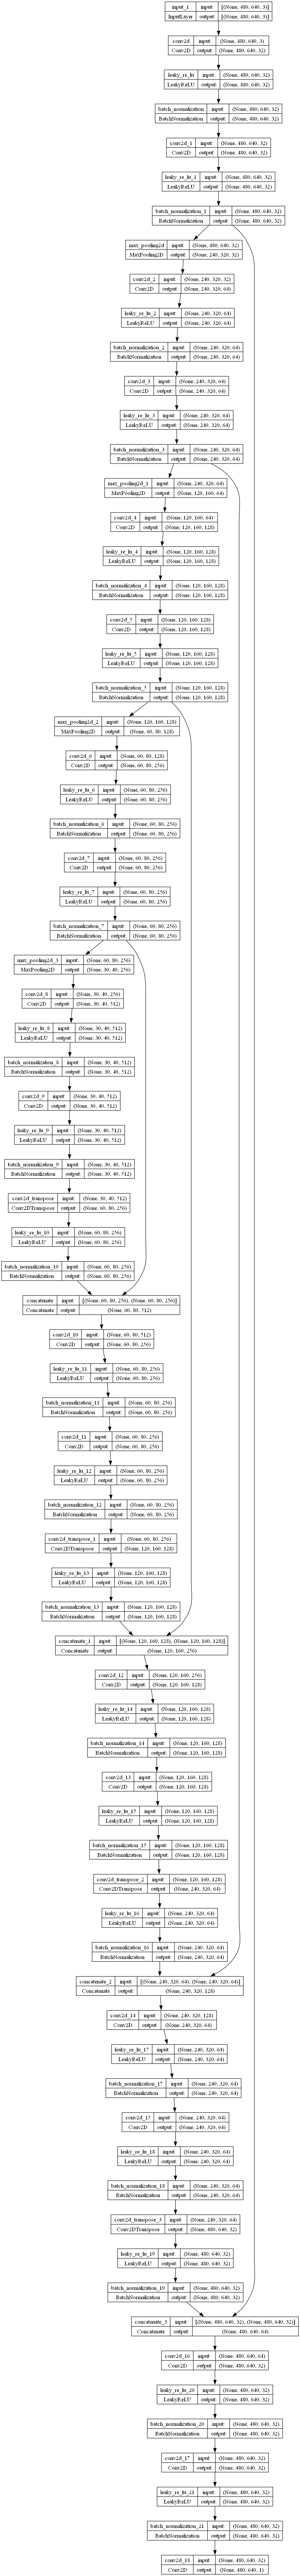

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 480, 640, 32)         896       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 480, 640, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 480, 640, 32)         128       ['leaky_re_lu[0][0]']         
 Normalization)                                                                               

In [20]:
unet_model = build_unet_model()
unet_model.summary()

In [21]:
# Custom Loss
def custom_loss(y_true, y_pred):
    # Define Weights for each Losses
    w_ssim = 1.0
    w_l1 = 0.1
    w_edges = 0.9
    
    # Structural Similarity Index (SSIM) Loss
    ssim_loss = tf.reduce_mean(
        1 - tf.image.ssim(
            y_true, y_pred,
            max_val=640, filter_size=7, k1=0.01**2, k2=0.03**2
        )
    )
    
    # L1 Loss
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Edge Loss
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
    
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y
    edges_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(abs(smoothness_y))
    
    # Final Loss
    loss = (ssim_loss * w_ssim) + (l1_loss * w_l1) + (edges_loss * w_edges)
    
    return loss

In [22]:
# Model Compiling
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=custom_loss,
)

# Callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=2
)
model_checkpoint = ModelCheckpoint(
    "best_unet_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)
callbacks = [early_stopping, model_checkpoint]

4.2. Model Training and Evaluation

In [ ]:
# Training
start_time = time.time()
unet_history = unet_model.fit(
    train_data,  
    validation_data=val_data,
    batch_size = 64,
    epochs=1,
    
    callbacks=callbacks
)
end_time = time.time()
unet_time = end_time-start_time

 139/5703 [..............................] - ETA: 27:15:07 - loss: 0.1165

In [ ]:
# Evaluation
unet_scores = unet_model.evaluate(
    test_data, 
    verbose=1
)

print("%s: %.4f" % ("Evaluate Test Custom Loss", unet_scores))

5. Results ¶

5.1. Training and Validation Loss

In [ ]:
# Training and Validation Loss

# Create Subplot
fig = go.Figure()

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#60442e"
    valid_color = "#83522e"

loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']

# Scatter Plot
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    )
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    )
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside")
fig.update_yaxes(title="Custom Loss", linecolor="Black", ticks="outside")

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Arial",
    width=600, height=450,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

5.2. RGB, Actual Depth, and Prediction Images

In [ ]:
# Create Subplots
fig, axs = plt.subplots(5, 6, figsize=(14, 12))

# Model
unet_model = tf.keras.models.load_model('best_unet_model.h5', custom_objects={'custom_loss': custom_loss})

# Plot
for i, (rgb, depth) in enumerate(val_data.take(10)):
    j = (i%2)*3
    
    # Predict
    pred = unet_model.predict(rgb, verbose=False)
    
    # RGB Image
    rgb = rgb[0]
    axs[i//2, j].imshow(rgb)
    axs[i//2, j].axis('off')
    axs[i//2, j].set_title("RGB", fontsize=6)
    
    # Ground Truth Image    
    depth = (depth - tf.reduce_min(depth)) / (tf.reduce_max(depth) - tf.reduce_min(depth))    
    depth = depth[0]
    depth = tf.squeeze(depth)
    
    axs[i//2, j+1].imshow(depth, cmap="inferno")
    axs[i//2, j+1].axis('off')
    axs[i//2, j+1].set_title("Ground Truth", fontsize=6)
    
    # Prediction Image
    pred = np.squeeze(pred[0])    
    axs[i//2, j+2].imshow(pred, cmap="inferno")
    axs[i//2, j+2].axis('off')
    axs[i//2, j+2].set_title("Prediction", fontsize=6)

# Title
plt.suptitle("RGB, Ground Truth, and Prediction Images", x=0.55, y=0.93)

# Show
plt.show()

In [ ]:
# Create Subplots
fig, axs = plt.subplots(5, 6, figsize=(14, 12))

# Model
unet_model = tf.keras.models.load_model('best_unet_model.h5', custom_objects={'custom_loss': custom_loss})

# Plot
for i, (rgb, depth) in enumerate(test_data.take(10)):
    j = (i%2)*3
    
    # Predict
    pred = unet_model.predict(rgb, verbose=False)
    
    # RGB Image
    rgb = rgb[0]
    axs[i//2, j].imshow(rgb)
    axs[i//2, j].axis('off')
    axs[i//2, j].set_title("RGB", fontsize=6)
    
    # Ground Truth Image    
    depth = (depth - tf.reduce_min(depth)) / (tf.reduce_max(depth) - tf.reduce_min(depth))    
    depth = depth[0]
    depth = tf.squeeze(depth)
    
    axs[i//2, j+1].imshow(depth, cmap="inferno")
    axs[i//2, j+1].axis('off')
    axs[i//2, j+1].set_title("Ground Truth", fontsize=6)
    
    # Prediction Image
    pred = np.squeeze(pred[0])    
    axs[i//2, j+2].imshow(pred, cmap="inferno")
    axs[i//2, j+2].axis('off')
    axs[i//2, j+2].set_title("Prediction", fontsize=6)

# Title
plt.suptitle("RGB, Ground Truth, and Prediction Images", x=0.55, y=0.93)

# Show
plt.show()